In [13]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
print('Required Frame works are included')

Required Frame works are included


In [14]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.3)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break

    return noOfClasses,class_names, train_generator, validation_generator
print('function for train_generator,validation_generator')

function for train_generator,validation_generator


In [15]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))
print('function - data normalize')

function - data normalize


In [16]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.EfficientNetV2B2(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )

    for layer in modelInput.layers:
        layer.trainable = False

    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()
print('function - model creation - EfficientNetV2B2')

function - model creation - EfficientNetV2B2


In [17]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'EfficientNetB2.h5', verbose=1, save_best_only=True)

    return model, annealer, checkpoint
print('function - parameter passing to model - EfficientNetB2')

function - parameter passing to model - EfficientNetB2


In [18]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )

    return history
print('function - model training')

function - model training


In [19]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    plt.figure(figsize=(12, 12))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss & Training and Validation Accuracy')
    plt.show()
print('function for model output plot')

function for model output plot


In [20]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)

def saveModel(model, className):
    model.save(className + " - EfficientNetB2.h5")
    print("Model Saved!")
print('function - model evaluation and model save to drive')

function - model evaluation and model save to drive


In [21]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')
print('function to plot confusion_matrix')

function to plot confusion_matrix


In [22]:
from sklearn import metrics
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)
    TPA=conf_mat[0][0]
    TPB=conf_mat[1][1]
    TPC=conf_mat[2][2]
    TPD=conf_mat[3][3]
    TPE=conf_mat[4][4]
    FPA=conf_mat[0][1]
    FPB=conf_mat[1][2]
    FPC=conf_mat[2][3]
    FPD=conf_mat[3][4]
    FNB=conf_mat[1][0]
    FNC=conf_mat[2][1]
    FND=conf_mat[3][2]
    FNE=conf_mat[4][3]

    ACC=round((TPA+TPB+TPC+TPD+TPE)/(TPA+TPB+TPC+TPD+TPE+FPA+FPB+FPC+FPD+FNB+FNC+FND+FNE),3)
    P=round((TPA+TPB+TPC+TPD+TPE)/((TPA+TPB+TPC+TPD+TPE)+(FPA+FPB+FPC+FPD)),2)
    RC=round((TPA+TPB+TPC+TPD+TPE)/((TPA+TPB+TPC+TPD+TPE)+(FNB+FNC+FND+FNE)),2)
    F1=round(2*(TPA+TPB+TPC+TPD+TPE)/(2*(TPA+TPB+TPC+TPD+TPE)+(FPA+FPB+FPC+FPD)+(FNB+FNC+FND+FNE)),3)
    print(ACC,P,RC,F1)
    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

    print(f"Accuracy :{ACC}")
    print(f"Precision: {P}")
    print(f"Recall: {RC}")
    print(f"F1 score: {F1}")

    # Create a figure object
    fig = plt.figure(figsize=(12, 12))

    # Add a subplot to the figure
    ax = fig.add_subplot(2,1,1)

    # Create the bar plot
    bars = ax.bar(['Precision','Recall','Accuracy','F1 Score'],[ACC,P,RC,F1])

    # Loop through the bars and add annotations
    for bar in bars:
      height = bar.get_height()
      ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
      textcoords="offset points", ha='center', va='bottom')

    # Show the plot
    plt.title('Performance metrics')
    plt.show()
print('function to plot True,Predicted,Performance metrics')

function to plot True,Predicted,Performance metrics


In [23]:
import os
mpath = "C://Windows//System32//project//Multiclass cancer//Multi Cancer"
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 20
lr = 0.001

for i in classPaths:
    print(i)
print('load input from google drive')

Breast Cancer
Lung and Colon Cancer
load input from google drive



Total :  Found 5000 files belonging to 5 classes.

For Training :  Found 3500 images belonging to 5 classes.

For Val :  Found 1500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
35839040/35839040 [==============================] - 180s 5us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (Non

C:\Users\sainh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 350s 2s/step - loss: 0.5519 - accuracy: 0.8997 - val_loss: 0.2330 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 2/20
110/110 [==============================] - ETA: 0s - loss: 0.2643 - accuracy: 0.9594
Epoch 2: val_loss did not improve from 0.23299
110/110 [==============================] - 226s 2s/step - loss: 0.2643 - accuracy: 0.9594 - val_loss: 0.3057 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 3/20
110/110 [==============================] - ETA: 0s - loss: 0.1517 - accuracy: 0.9774
Epoch 3: val_loss improved from 0.23299 to 0.18022, saving model to Lung and Colon Cancer EfficientNetB2.h5
110/110 [==============================] - 238s 2s/step - loss: 0.1517 - accuracy: 0.9774 - val_loss: 0.1802 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 4/20
110/110 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9837
Epoch 4: val_loss did not improve from 0.18022
110/110 [==============================] - 247s 2s/step - loss: 0.0876 - ac

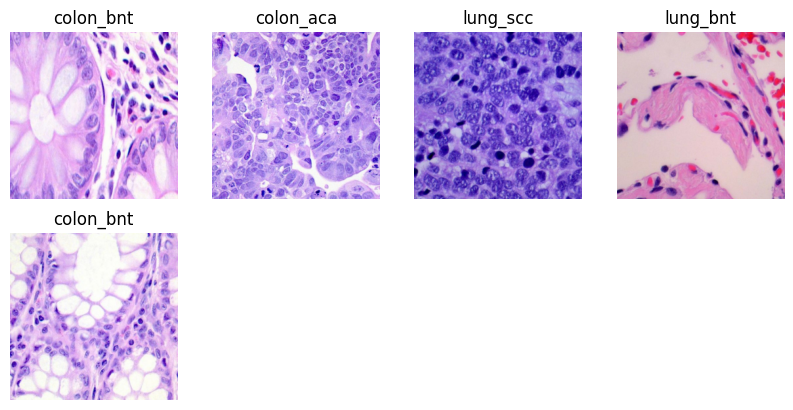

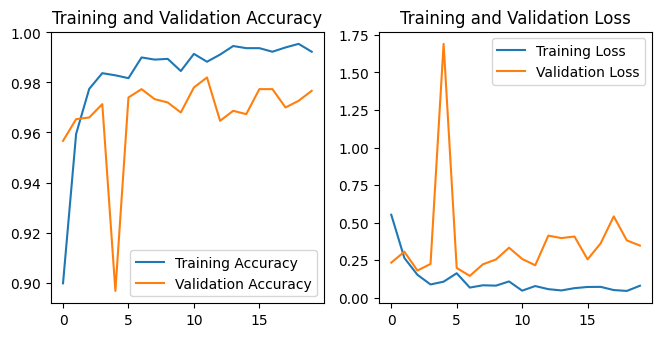

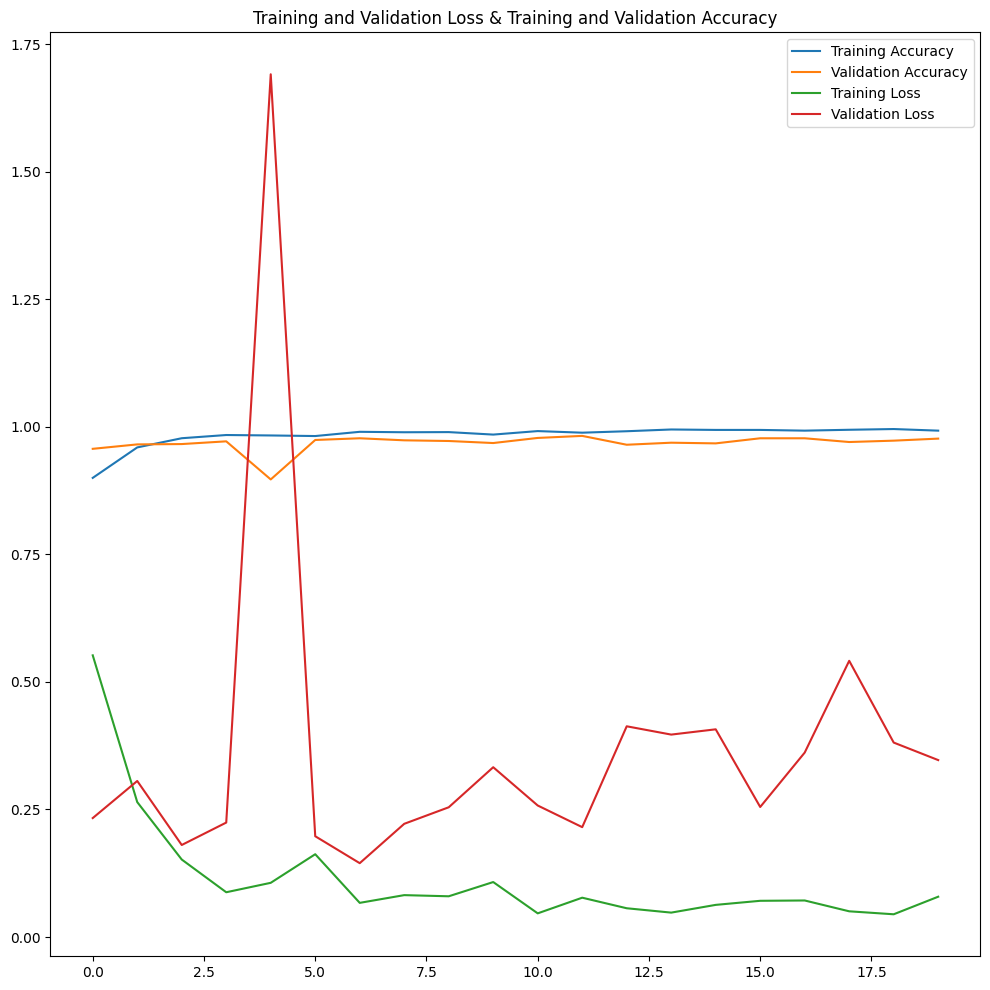

In [24]:
className = 'Lung and Colon Cancer '
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
#evalModel(curModel)
#saveModel(curModel, className)
#callPlot(curModel, className, class_names)

47/47 [==============================] - 76s 2s/step - loss: 0.3466 - accuracy: 0.9767
Accuracy on the Test Set = 97.67 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
47/47 [==============================] - 94s 2s/step
Predicted :  [0 0 0 ... 4 4 4]
0.995 1.0 1.0 0.997


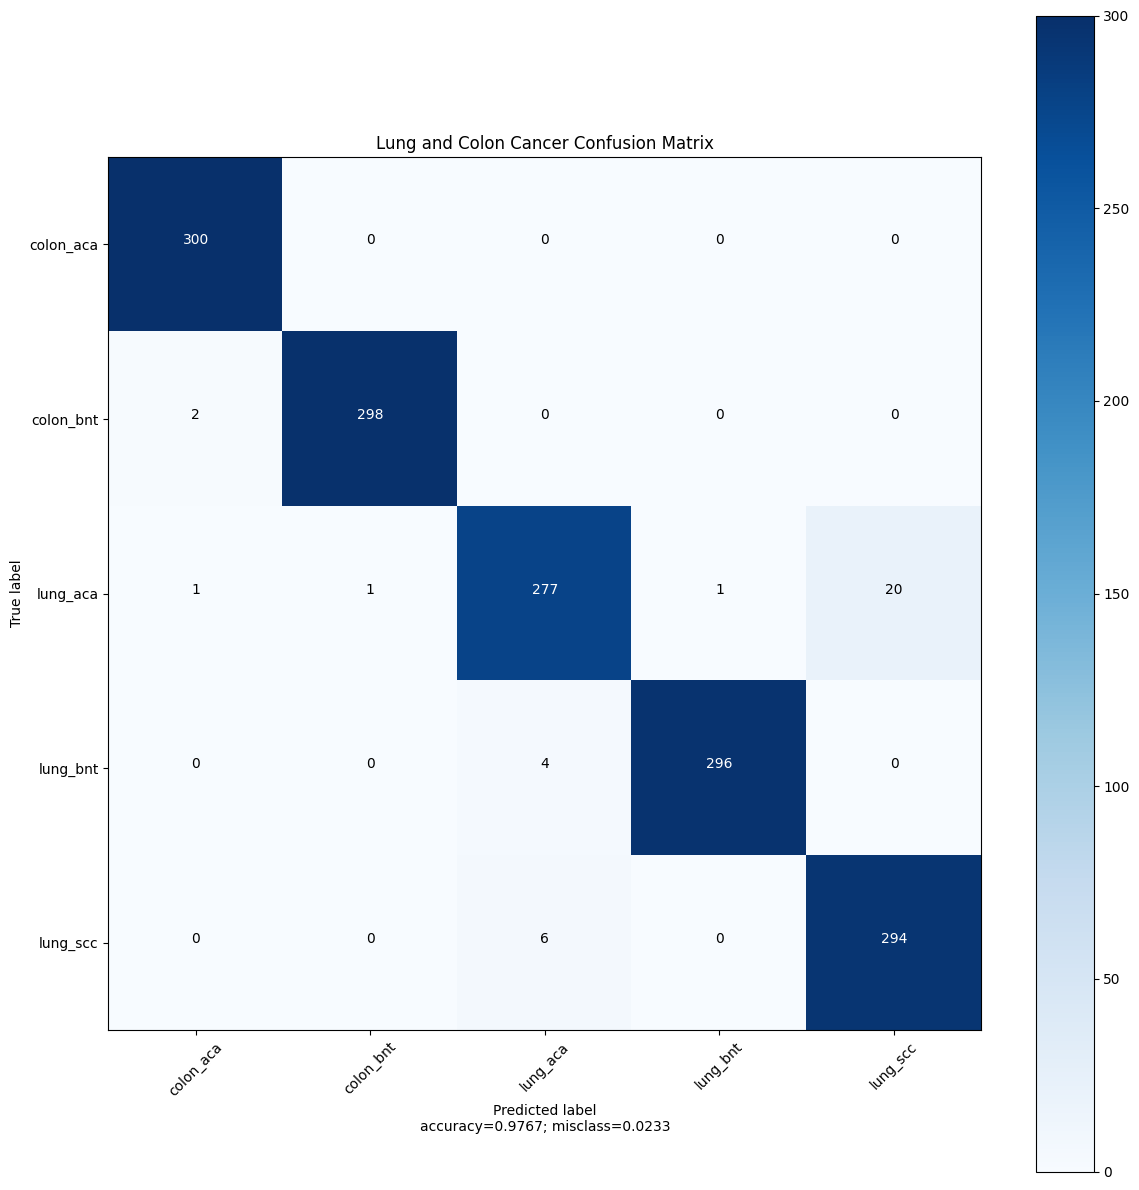

Accuracy :0.995
Precision: 1.0
Recall: 1.0
F1 score: 0.997


<Figure size 640x480 with 0 Axes>

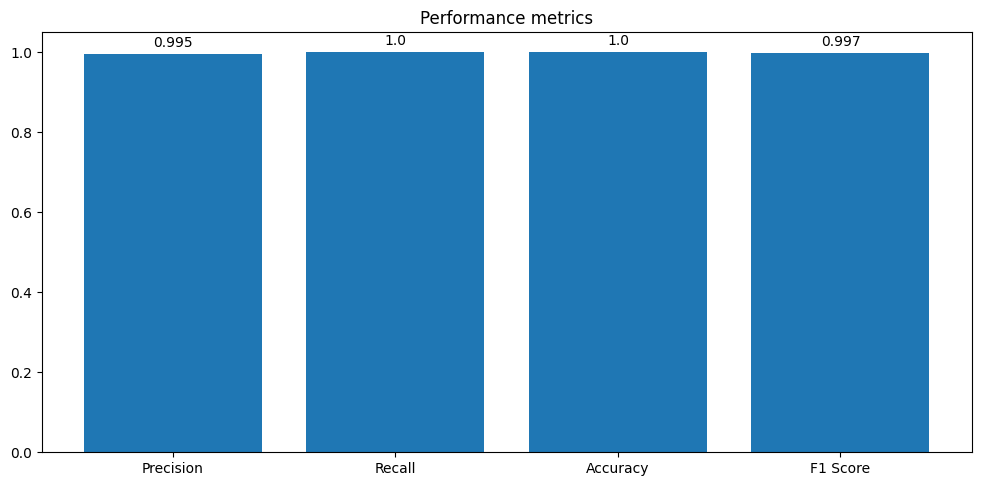

In [25]:
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

47/47 [==============================] - 76s 2s/step


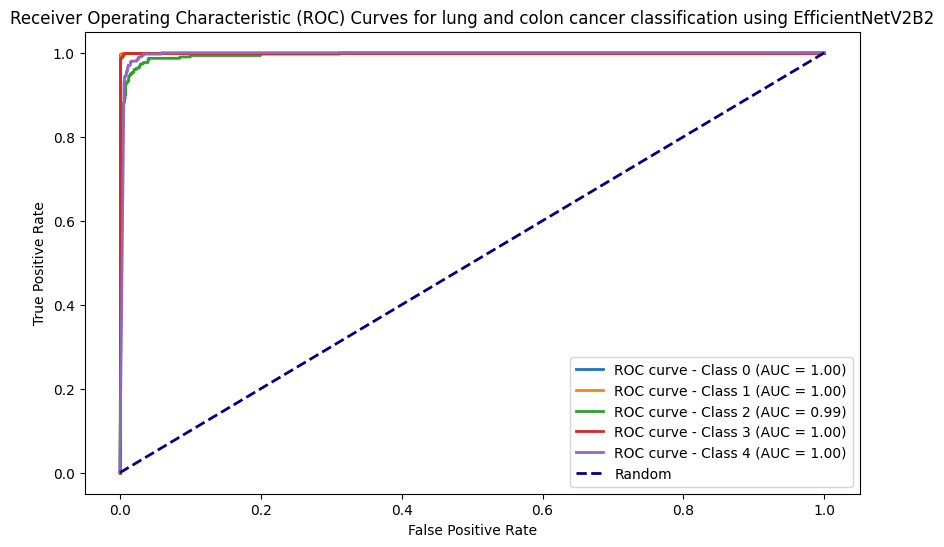

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

num_classes = 5
model=curModel
# Assuming you have a TensorFlow model and validation data
# Example:
# model = tf.keras.models.load_model('your_model.h5')
# valid_batches = your_validation_data_generator
y_pred = model.predict(validation_generator)
# Get predictions from the model
predictions =  y_pred  # Make sure y_pred is a matrix of predicted probabilities

# Convert one-hot encoded labels to integers
y_true = validation_generator.classes

# Convert integer labels to one-hot encoding
y_true_one_hot = to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and area under the curve (AUC) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for individual classes
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve - Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for lung and colon cancer classification using EfficientNetV2B2')
plt.legend(loc='lower right')
plt.show()


47/47 [==============================] - 74s 2s/step


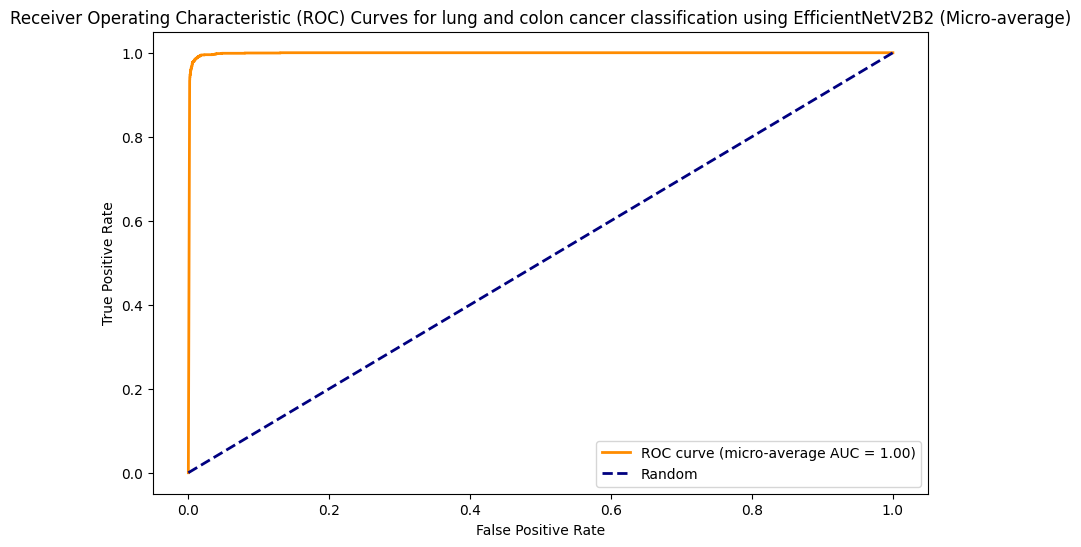

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

num_classes = 5
model=curModel
# Assuming you have a TensorFlow model and validation data
# Example:
# model = tf.keras.models.load_model('your_model.h5')
# valid_batches = your_validation_data_generator
y_pred = model.predict(validation_generator)
# Get predictions from the model
predictions =  y_pred  # Make sure y_pred is a matrix of predicted probabilities

# Convert one-hot encoded labels to integers
y_true = validation_generator.classes

# Convert integer labels to one-hot encoding
y_true_one_hot = to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and area under the curve (AUC) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Ensure that the loop does not access indices beyond the bounds of the predictions array
for i in range(min(num_classes, predictions.shape[1])):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_one_hot.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the micro-average ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2, label=f'ROC curve (micro-average AUC = {roc_auc["micro"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for lung and colon cancer classification using EfficientNetV2B2 (Micro-average)')
plt.legend(loc='lower right')
plt.show()


47/47 [==============================] - 73s 2s/step


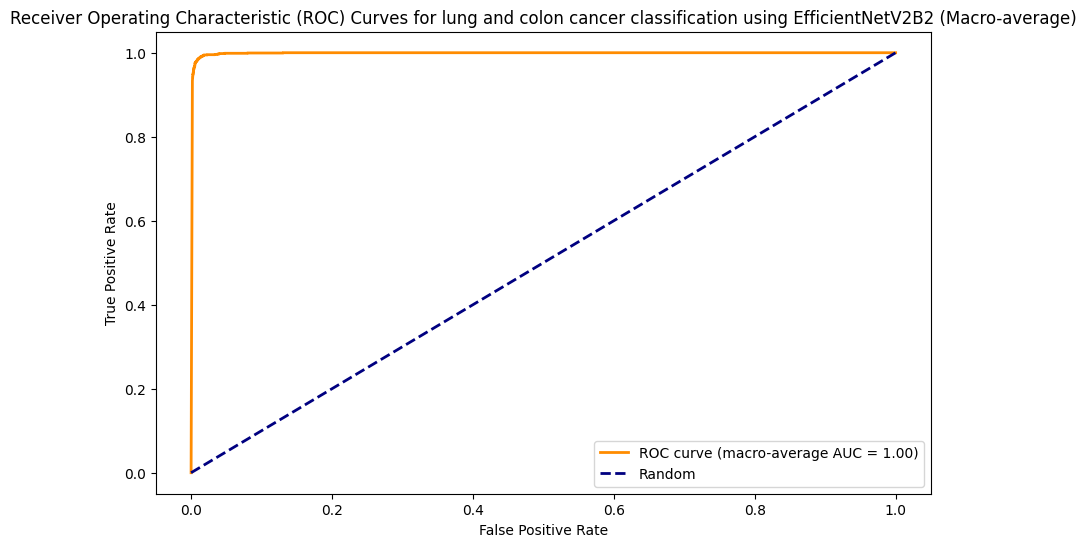

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

num_classes = 5
model=curModel
# Assuming you have a TensorFlow model and validation data
# Example:
# model = tf.keras.models.load_model('your_model.h5')
# valid_batches = your_validation_data_generator
y_pred = model.predict(validation_generator)
# Get predictions from the model
predictions =  y_pred  # Make sure y_pred is a matrix of predicted probabilities

# Convert one-hot encoded labels to integers
y_true = validation_generator.classes

# Convert integer labels to one-hot encoding
y_true_one_hot = to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and area under the curve (AUC) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Ensure that the loop does not access indices beyond the bounds of the predictions array
for i in range(min(num_classes, predictions.shape[1])):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Macro-average ROC curve and AUC
fpr["macro"], tpr["macro"], _ = roc_curve(y_true_one_hot.ravel(), predictions.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the micro-average ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr["macro"], tpr["macro"], color='darkorange', lw=2, label=f'ROC curve (macro-average AUC = {roc_auc["macro"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for lung and colon cancer classification using EfficientNetV2B2 (Macro-average)')
plt.legend(loc='lower right')
plt.show()


Total :  Found 2000 files belonging to 2 classes.

For Training :  Found 1400 images belonging to 2 classes.

For Val :  Found 600 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          0         ['rescaling_2[0][0]']         
 tion)                   

C:\Users\sainh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 218s 3s/step - loss: 0.2395 - accuracy: 0.9557 - val_loss: 0.0695 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 2/20
44/44 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9979
Epoch 2: val_loss did not improve from 0.06953
44/44 [==============================] - 107s 2s/step - loss: 0.0108 - accuracy: 0.9979 - val_loss: 0.0840 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 3/20
44/44 [==============================] - ETA: 0s - loss: 1.3106e-04 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.06953
44/44 [==============================] - 100s 2s/step - loss: 1.3106e-04 - accuracy: 1.0000 - val_loss: 0.0749 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 4/20
44/44 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9986
Epoch 4: val_loss did not improve from 0.06953
44/44 [==============================] - 104s 2s/step - loss: 0.0039 - accuracy: 0.9986 - val_loss: 0.0904 - val_accuracy: 0.9883 - lr: 0.00

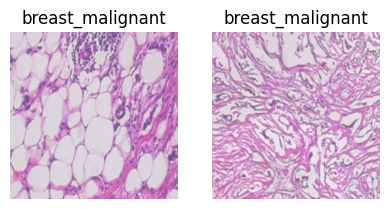

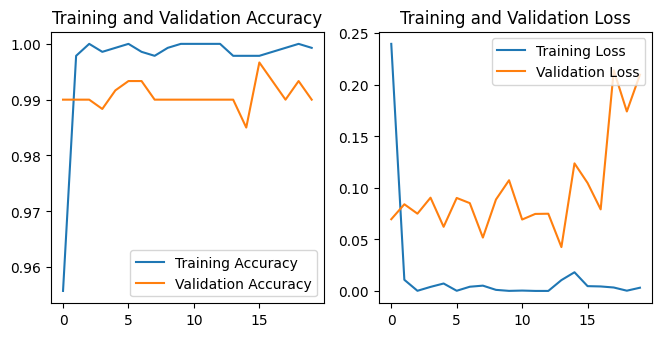

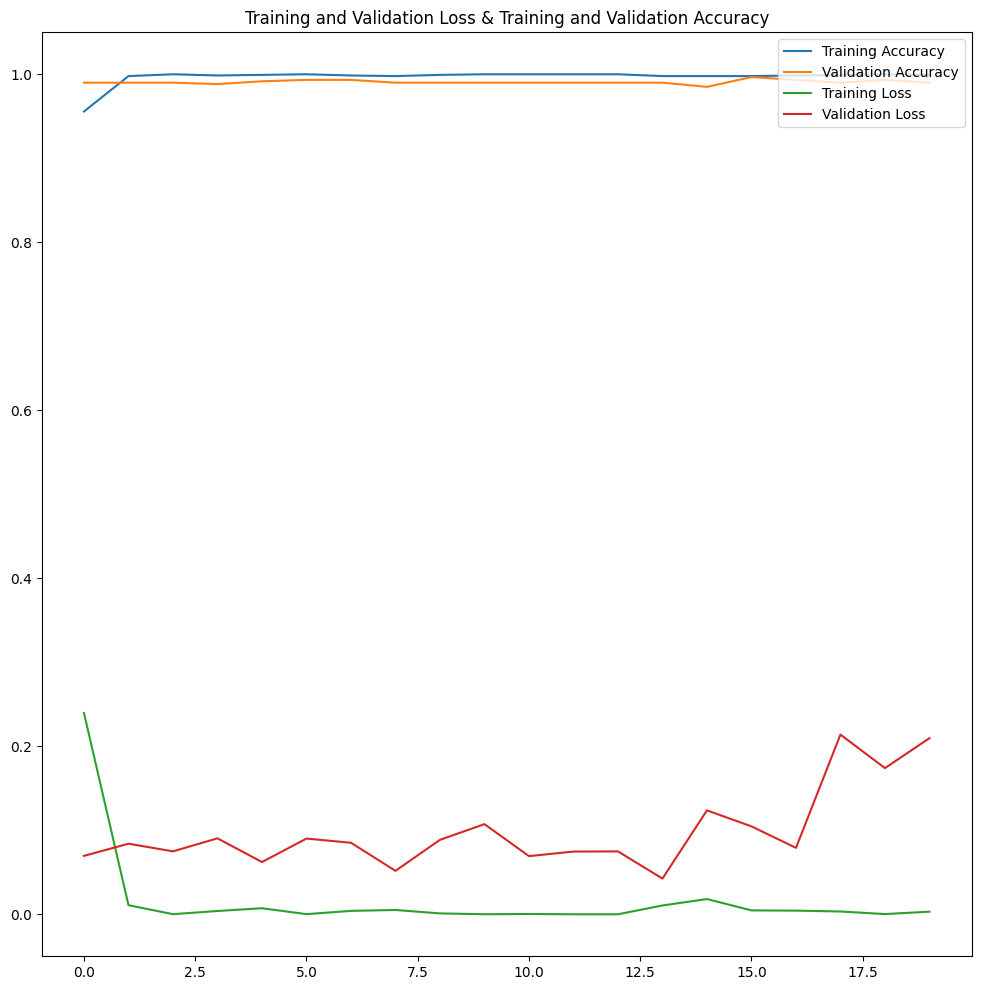

In [29]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
#evalModel(curModel)
#saveModel(curModel, className)
#callPlot(curModel, className, class_names)

In [30]:
from sklearn import metrics
def callPlot1(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)
    TP=conf_mat[0][0]
    FN=conf_mat[0][1]
    FP=conf_mat[1][0]
    TN=conf_mat[1][1]
    ACC=round((TP+TN)/(TP+TN+FP+FN),3)
    P=round(TP/(TP+FP),3)
    RC=round(TP/(TP+FN),3)
    F1=(2*P*RC)/(P+RC)
    F1=round(F1, 3)
    print(ACC,P,RC,F1)
    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

    print(f"Accuracy :{ACC}")
    print(f"Precision: {P}")
    print(f"Recall: {RC}")
    print(f"F1 score: {F1}")

    # Create a figure object
    fig = plt.figure(figsize=(12, 12))

    # Add a subplot to the figure
    ax = fig.add_subplot(2,1,1)

    # Create the bar plot
    bars = ax.bar(['Precision','Recall','Accuracy','F1 Score'],[ACC,P,RC,F1])

    # Loop through the bars and add annotations
    for bar in bars:
      height = bar.get_height()
      ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
      textcoords="offset points", ha='center', va='bottom')

    # Show the plot
    plt.title('Performance metrics')
    plt.show()

19/19 [==============================] - 28s 1s/step - loss: 0.2096 - accuracy: 0.9900
Accuracy on the Test Set = 99.00 %
Model Saved!
True :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

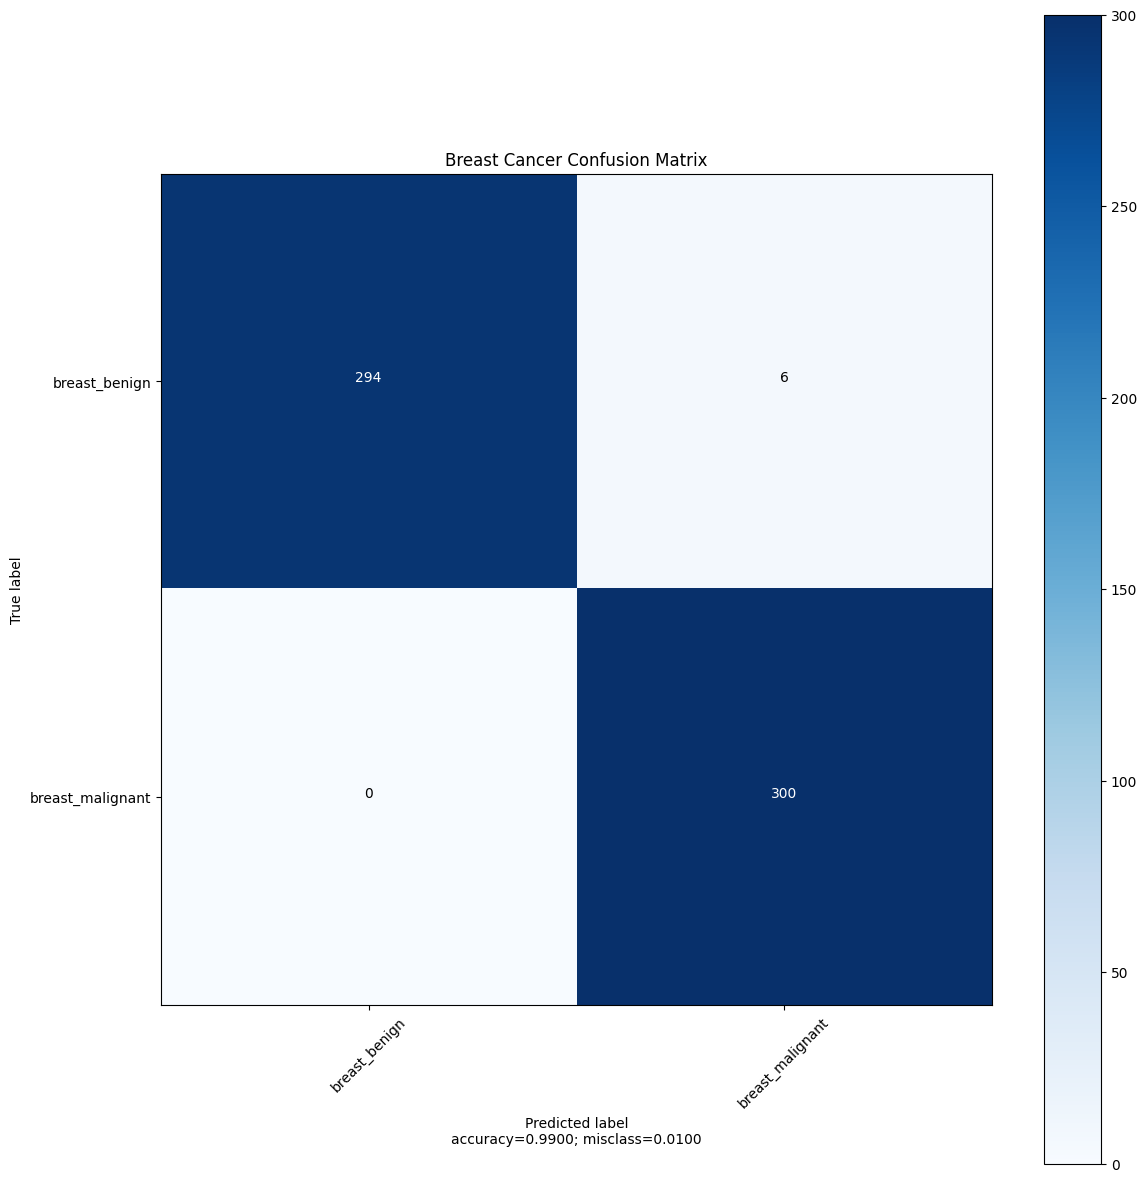

Accuracy :0.99
Precision: 1.0
Recall: 0.98
F1 score: 0.99


<Figure size 640x480 with 0 Axes>

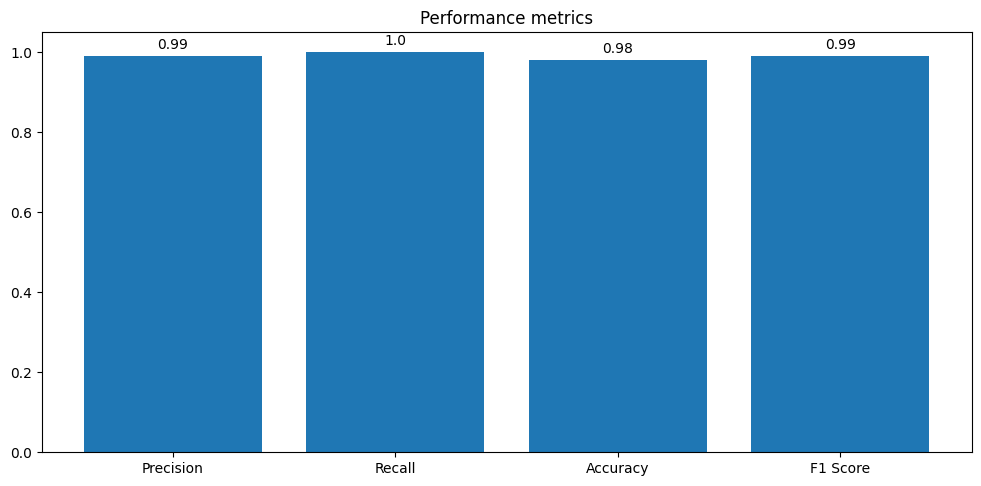

In [31]:
evalModel(curModel)
saveModel(curModel, className)
callPlot1(curModel, className, class_names)

19/19 [==============================] - 30s 2s/step


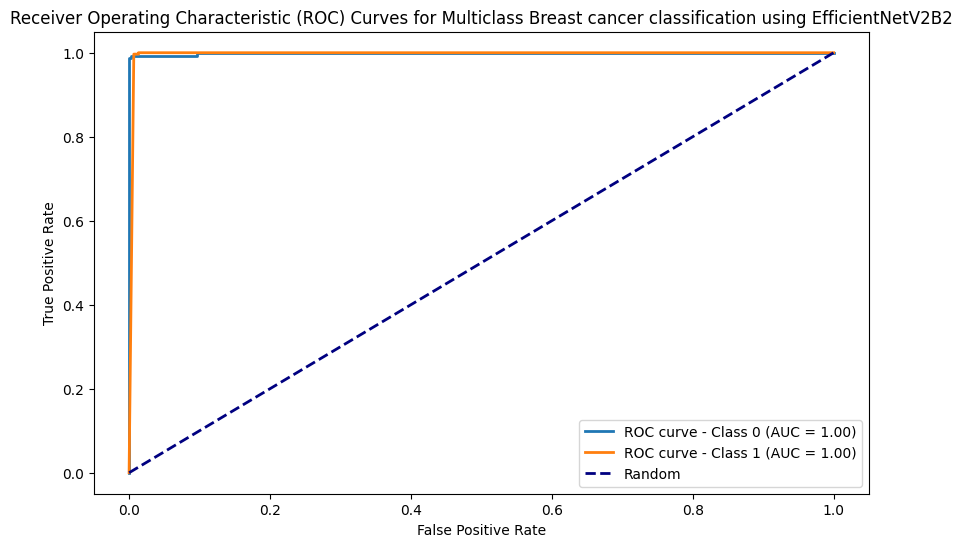

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

num_classes = 2
model=curModel
# Assuming you have a TensorFlow model and validation data
# Example:
# model = tf.keras.models.load_model('your_model.h5')
# valid_batches = your_validation_data_generator
y_pred = model.predict(validation_generator)
# Get predictions from the model
predictions =  y_pred  # Make sure y_pred is a matrix of predicted probabilities

# Convert one-hot encoded labels to integers
y_true = validation_generator.classes

# Convert integer labels to one-hot encoding
y_true_one_hot = to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and area under the curve (AUC) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for individual classes
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve - Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multiclass Breast cancer classification using EfficientNetV2B2')
plt.legend(loc='lower right')
plt.show()

19/19 [==============================] - 26s 1s/step


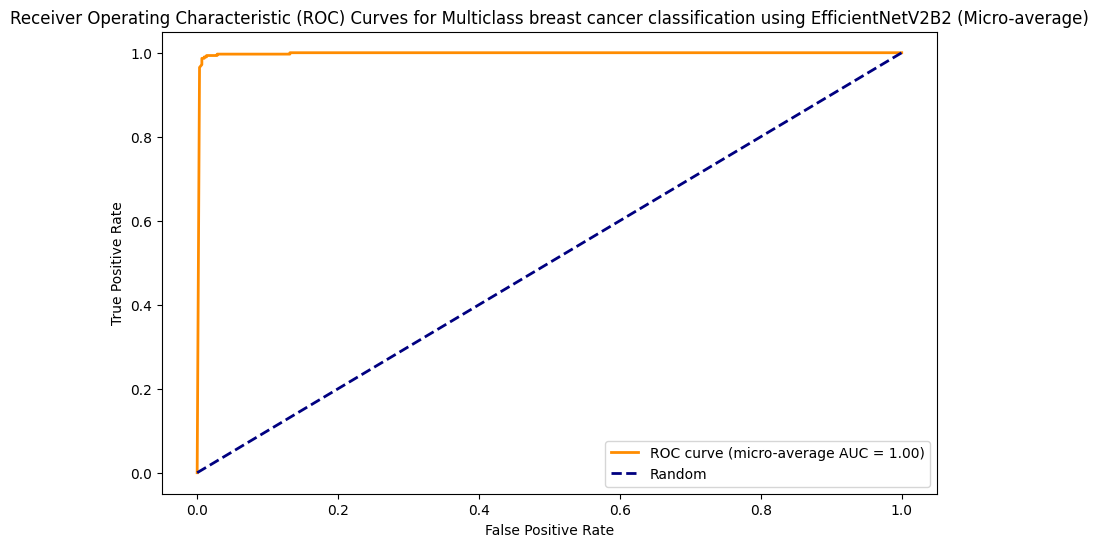

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

num_classes = 2
model=curModel
# Assuming you have a TensorFlow model and validation data
# Example:
# model = tf.keras.models.load_model('your_model.h5')
# valid_batches = your_validation_data_generator
y_pred = model.predict(validation_generator)
# Get predictions from the model
predictions =  y_pred  # Make sure y_pred is a matrix of predicted probabilities

# Convert one-hot encoded labels to integers
y_true = validation_generator.classes

# Convert integer labels to one-hot encoding
y_true_one_hot = to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and area under the curve (AUC) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Ensure that the loop does not access indices beyond the bounds of the predictions array
for i in range(min(num_classes, predictions.shape[1])):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_one_hot.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the micro-average ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2, label=f'ROC curve (micro-average AUC = {roc_auc["micro"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multiclass breast cancer classification using EfficientNetV2B2 (Micro-average)')
plt.legend(loc='lower right')
plt.show()

19/19 [==============================] - 29s 1s/step


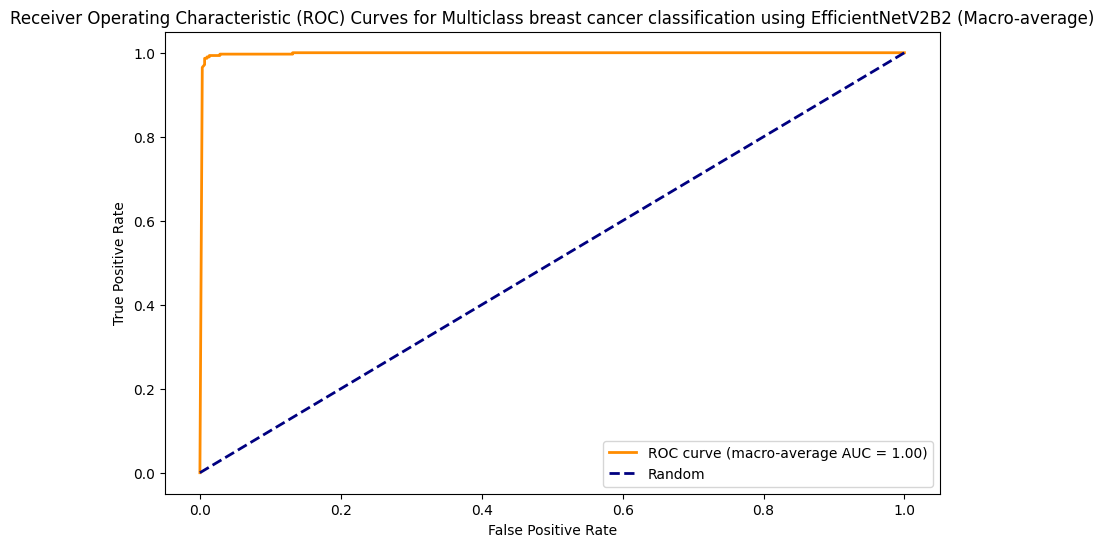

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

num_classes = 2
model=curModel
# Assuming you have a TensorFlow model and validation data
# Example:
# model = tf.keras.models.load_model('your_model.h5')
# valid_batches = your_validation_data_generator
y_pred = model.predict(validation_generator)
# Get predictions from the model
predictions =  y_pred  # Make sure y_pred is a matrix of predicted probabilities

# Convert one-hot encoded labels to integers
y_true = validation_generator.classes

# Convert integer labels to one-hot encoding
y_true_one_hot = to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and area under the curve (AUC) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Ensure that the loop does not access indices beyond the bounds of the predictions array
for i in range(min(num_classes, predictions.shape[1])):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Macro-average ROC curve and AUC
fpr["macro"], tpr["macro"], _ = roc_curve(y_true_one_hot.ravel(), predictions.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the micro-average ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr["macro"], tpr["macro"], color='darkorange', lw=2, label=f'ROC curve (macro-average AUC = {roc_auc["macro"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multiclass breast cancer classification using EfficientNetV2B2 (Macro-average)')
plt.legend(loc='lower right')
plt.show()